In [95]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
#from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
import math

## Model 1

In [96]:
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2021, 1, 1)

data = pdr.get_data_yahoo('^DJI', start, end)
data = data.reset_index()
data = data.dropna()
#data1 = data.copy()

[*********************100%***********************]  1 of 1 completed


In [97]:
train_data = data[data['Date']<"2018-01-01"]
test_data = data[data['Date']>="2018-01-01"]

In [98]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [99]:
window_size = 100

x_train=[]
y_train=[]

for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [100]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [101]:
%%capture

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
history = model.fit(x_train, y_train, epochs=10, batch_size=30,callbacks=[es])

In [102]:
actual_prices=test_data['Close'].values

total_dataset=pd.concat((train_data['Close'], test_data['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-window_size:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [103]:
x_test=[]

for x in range(window_size, len(model_inputs)):
    x_test.append(model_inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

24/24 [==============================] - 2s 34ms/step


In [104]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

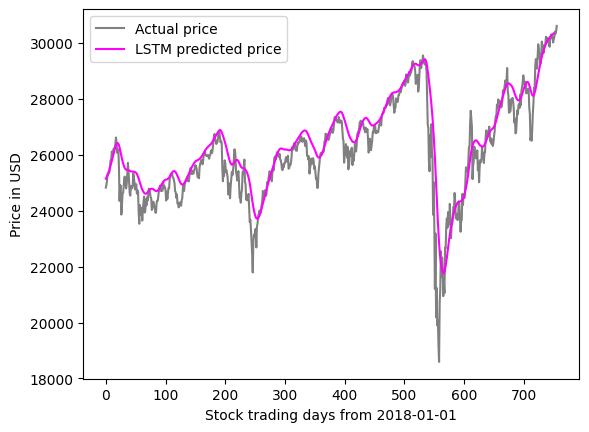

In [105]:
#Plot test predction
plt.plot(test_data.reset_index()['Close'], color = 'grey', label = 'Actual price')
plt.plot(predicted_prices, color = 'magenta', label = 'LSTM predicted price')

plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

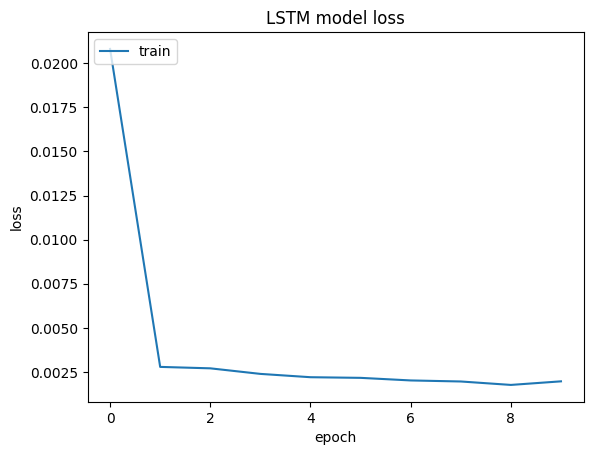

In [106]:
plt.plot(history.history['loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [107]:
math.sqrt(metrics.mean_squared_error(actual_prices[5:],predicted_prices))

1042.918958747187

In [108]:
metrics.mean_absolute_error(actual_prices[5:],predicted_prices)

637.2589177971039

## Model 2

In [109]:
data2 = test_data.copy()

In [110]:
data2['SMA'] = data2['Close'].rolling(window_size).mean()

In [111]:
data2 = data2.reset_index()

In [112]:
df = pd.DataFrame({'act1':actual_prices.ravel(), 'pred1':predicted_prices1.ravel()})

In [113]:
data2 = pd.merge(data2, df, left_on ='Close', right_on ='act1',how='left')

<function matplotlib.pyplot.show(close=None, block=None)>

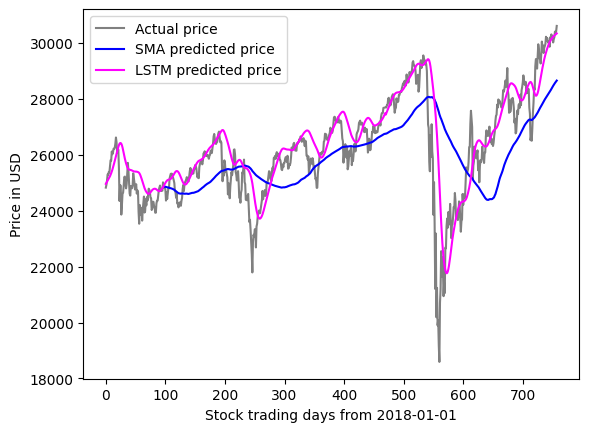

In [114]:
plt.plot(data2['act1'], label = 'Actual price', color = 'grey')
plt.plot(data2['SMA'], label = 'SMA predicted price', color = 'blue')
plt.plot(data2['pred1'], label = 'LSTM predicted price', color = 'magenta')





plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in USD')

plt.legend()
plt.show

In [115]:
math.sqrt(metrics.mean_squared_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna()))

1704.7622130938291

In [116]:
metrics.mean_absolute_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna())

1254.6923580057378

## Differenced data for Model 1

In [ ]:
data1 = data.copy()
data1['Close'][1:] = np.diff(data1['Close'])

In [ ]:
train_data1 = data1[data1['Date']<="2018-01-01"]
test_data1 = data1[data1['Date']>"2018-01-01"]

In [ ]:
#train_data1['Close'] = train_data1['Close'].diff(periods=1).dropna()
#train_data1['Close'] = train_data1['Close']/10
#train_data1 = train_data1.dropna()
#train_data1['Close'] = train_data1['Close'].dropna()

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data1['Close'].values.reshape(-1,1))

In [ ]:
#df = pd.DataFrame(scaled_data, columns = ['Close'])

In [ ]:
#df['Close'] = df['Close'].diff(periods=1).dropna()

In [ ]:
#df = df.dropna()
#scaled_data = train_data1['Close'].values.reshape(-1,1)

In [ ]:
window_size = 3

x_train=[]
y_train=[]

for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
%%capture
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

In [ ]:
#Load Test Data
#test_start=dt.datetime(2021, 1, 1)
#test_end=dt.datetime.now()

#test_data = pdr.get_data_yahoo('^DJI', test_start, test_end)
actual_prices=test_data1['Close'].values

total_dataset=pd.concat((train_data1['Close'], test_data1['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-window_size:].values
model_inputs = model_inputs.reshape(-1, 1)
#model_inputs = scaler.transform(model_inputs)

In [ ]:
x_test=[]

for x in range(window_size, len(model_inputs)):
    x_test.append(model_inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
#predicted_prices = rebuild_diffed(predicted_prices, 24824.009766).reshape(-1, 1)
#predicted_prices=scaler.inverse_transform(predicted_prices)

In [ ]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

In [ ]:
#Plot test predction
plt.plot(test_data1.reset_index()['Close'], color = 'gray', label = 'act')
plt.plot(predicted_prices, color = 'orange', label = 'pred')

plt.xlabel('time')
plt.ylabel('differenced price')
plt.legend()
plt.show()

In [ ]:
########################################################################

# Data analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

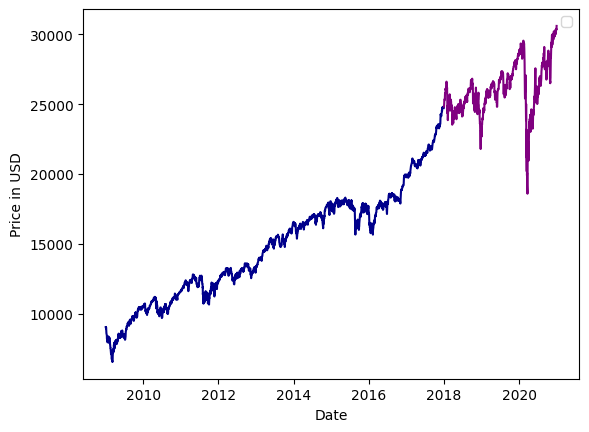

In [459]:
plt.plot(train_data['Date'],train_data['Close'], color ='darkblue')
plt.plot(test_data['Date'],test_data['Close'],color = 'purple')
plt.xlabel('Date')
plt.ylabel('Price in USD')

plt.legend()
plt.show


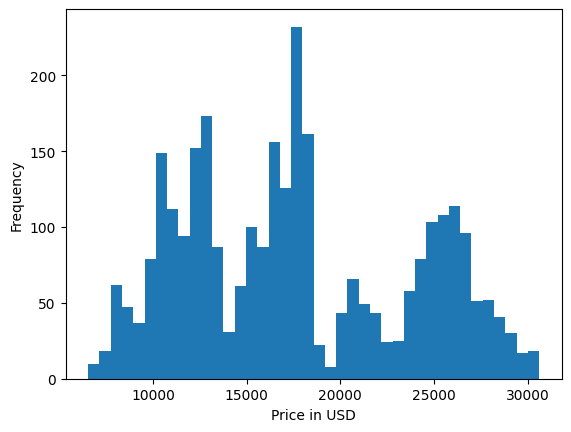

In [437]:
plt.hist(data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

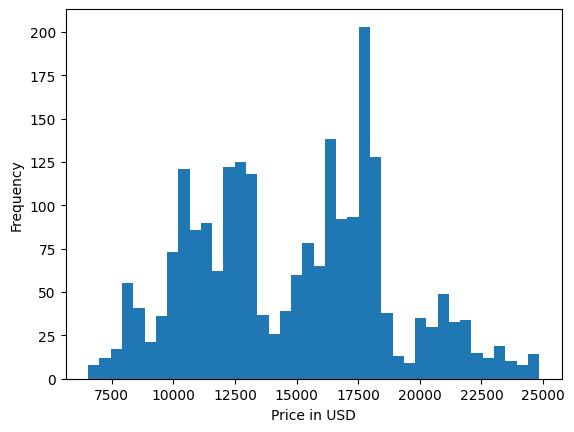

In [438]:
plt.hist(train_data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

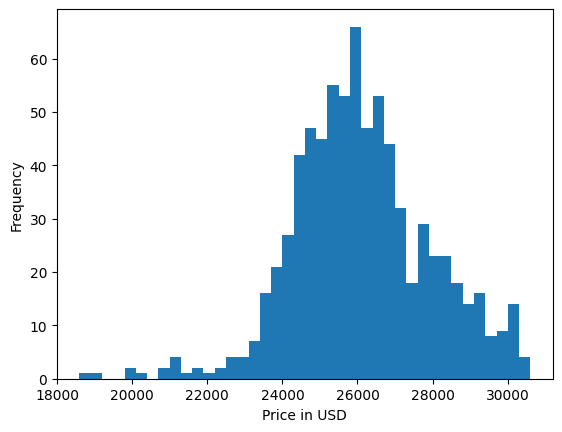

In [439]:
plt.hist(test_data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [440]:
adfuller(data['Close'])

(-0.2374306644271012,
 0.933910414810336,
 27,
 2993,
 {'1%': -3.432536741492438,
  '5%': -2.862506160743024,
  '10%': -2.5672843129045173},
 40354.406843980214)

In [ ]:
adfuller(train_data['Close'])

In [ ]:
adfuller(test_data['Close'])

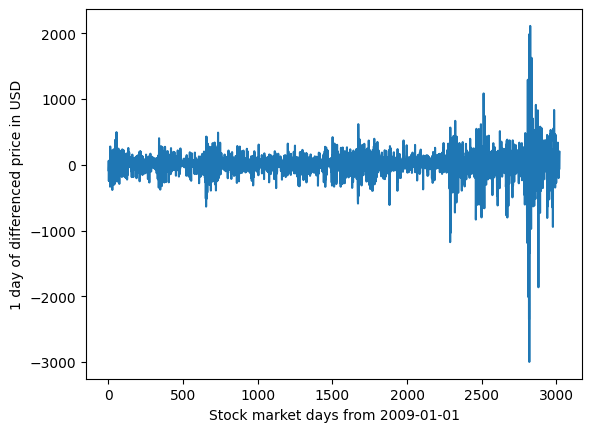

In [444]:
plt.plot(data['Close'].diff(periods=1).dropna())
plt.xlabel('Stock market days from 2009-01-01')
plt.ylabel('1 day of differenced price in USD')
plt.show()

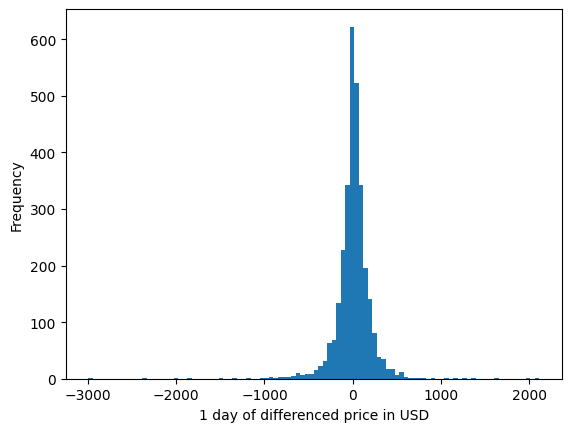

In [447]:
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 100)
plt.xlabel('1 day of differenced price in USD')
plt.ylabel('Frequency')
plt.show()

In [ ]:
adfuller(data['Close'].dropna().diff(periods=1).dropna()) 

In [ ]:
adfuller(scaled_data)
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 50)

In [ ]:
#perform augmented Dickey-Fuller test
adfuller(data)

(-0.9753836234744063,
 0.7621363564361013,
 0,
 12,
 {'1%': -4.137829282407408,
  '5%': -3.1549724074074077,
  '10%': -2.7144769444444443},
 31.2466098872313)
Here’s how to interpret the most important values in the output:

Test statistic: -0.97538
P-value: 0.7621
Since the p-value is not less than .05, we fail to reject the null hypothesis.

This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


## För att få bort non-stationarity kan vi differentiera
#df["series"].diff(periods=1)

